<a href="https://colab.research.google.com/github/naqsaah123/Final_Project/blob/main/My_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setting Up Paths and Importing Libaries

In [ ]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


base_dir = '/content/drive/MyDrive/Pics/Data'  # path to base directory
balanced_dir = '/content/drive/MyDrive/Pics/BalancedData'
classes = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
target_per_class = 5000
img_size = (224, 224)

# Images in the Original Dataset

In [ ]:
# Replace with the path to your main folder (the one containing subfolders with images)
main_folder = '/content/drive/MyDrive/Pics/Data'

# Common image file extensions
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')

# Dictionary to store image counts
image_counts = {}

# Walk through each subfolder
for root, dirs, files in os.walk(main_folder):
    # Only consider immediate subdirectories
    if root == main_folder:
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            count = sum(1 for file in os.listdir(subdir_path) if file.lower().endswith(image_extensions))
            image_counts[subdir] = count

# Print the results
for folder, count in image_counts.items():
    print(f"{folder}: {count} images")


Mild Dementia: 5002 images
Moderate Dementia: 488 images
Non Demented: 58477 images
Very mild Dementia: 7590 images


# Organize and Balance the Dataset with Augmentation

In [ ]:


# === CLEAN AND CREATE OUTPUT FOLDER ===
if os.path.exists(balanced_dir):
    shutil.rmtree(balanced_dir)
os.makedirs(balanced_dir)

# === IMAGE AUGMENTATION SETUP ===
datagen = ImageDataGenerator(
    rescale=1./255,           # rescale to the range of 0-1
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# === PROCESS EACH CLASS ===
for label in classes:
    original_path = os.path.join(base_dir, label)
    dest_path = os.path.join(balanced_dir, label)
    os.makedirs(dest_path, exist_ok=True)

    all_images = os.listdir(original_path)
    random.shuffle(all_images)
    num_images = len(all_images)

    print(f"{label}: {num_images} images")

    if num_images > target_per_class:
        #  Too many → downsample
        selected_images = all_images[:target_per_class]
        for img in selected_images:
            shutil.copy(os.path.join(original_path, img), os.path.join(dest_path, img))

    else:
        #  Copy all real images
        for img in all_images:
            shutil.copy(os.path.join(original_path, img), os.path.join(dest_path, img))

        #  Too few → augment the rest
        to_augment = target_per_class - num_images
        print(f"Augmenting {to_augment} images for {label}...")

        aug_gen = datagen.flow_from_directory(
            base_dir,
            classes=[label],
            target_size=img_size,
            batch_size=1,
            save_to_dir=dest_path,
            save_format='jpg',
            shuffle=True
        )

        for _ in range(to_augment):
            next(aug_gen)  # FIXED HERE

Mild Dementia: 5002 images
Moderate Dementia: 488 images
Augmenting 4512 images for Moderate Dementia...
Found 488 images belonging to 1 classes.
Non Demented: 58477 images
Very mild Dementia: 6275 images


In [ ]:
# Replace with the path to your main folder (the one containing subfolders with images)
main_folder = '/content/drive/MyDrive/Pics/BalancedData'

# Common image file extensions
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')

# Dictionary to store image counts
image_counts = {}

# Walk through each subfolder
for root, dirs, files in os.walk(main_folder):
    # Only consider immediate subdirectories
    if root == main_folder:
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            count = sum(1 for file in os.listdir(subdir_path) if file.lower().endswith(image_extensions))
            image_counts[subdir] = count

# Print the results
for folder, count in image_counts.items():
    print(f"{folder}: {count} images")


Mild Dementia: 5000 images
Moderate Dementia: 5000 images
Non Demented: 5000 images
Very mild Dementia: 5000 images
train: 0 images
val: 0 images
test: 0 images


# Showing 4 images per class


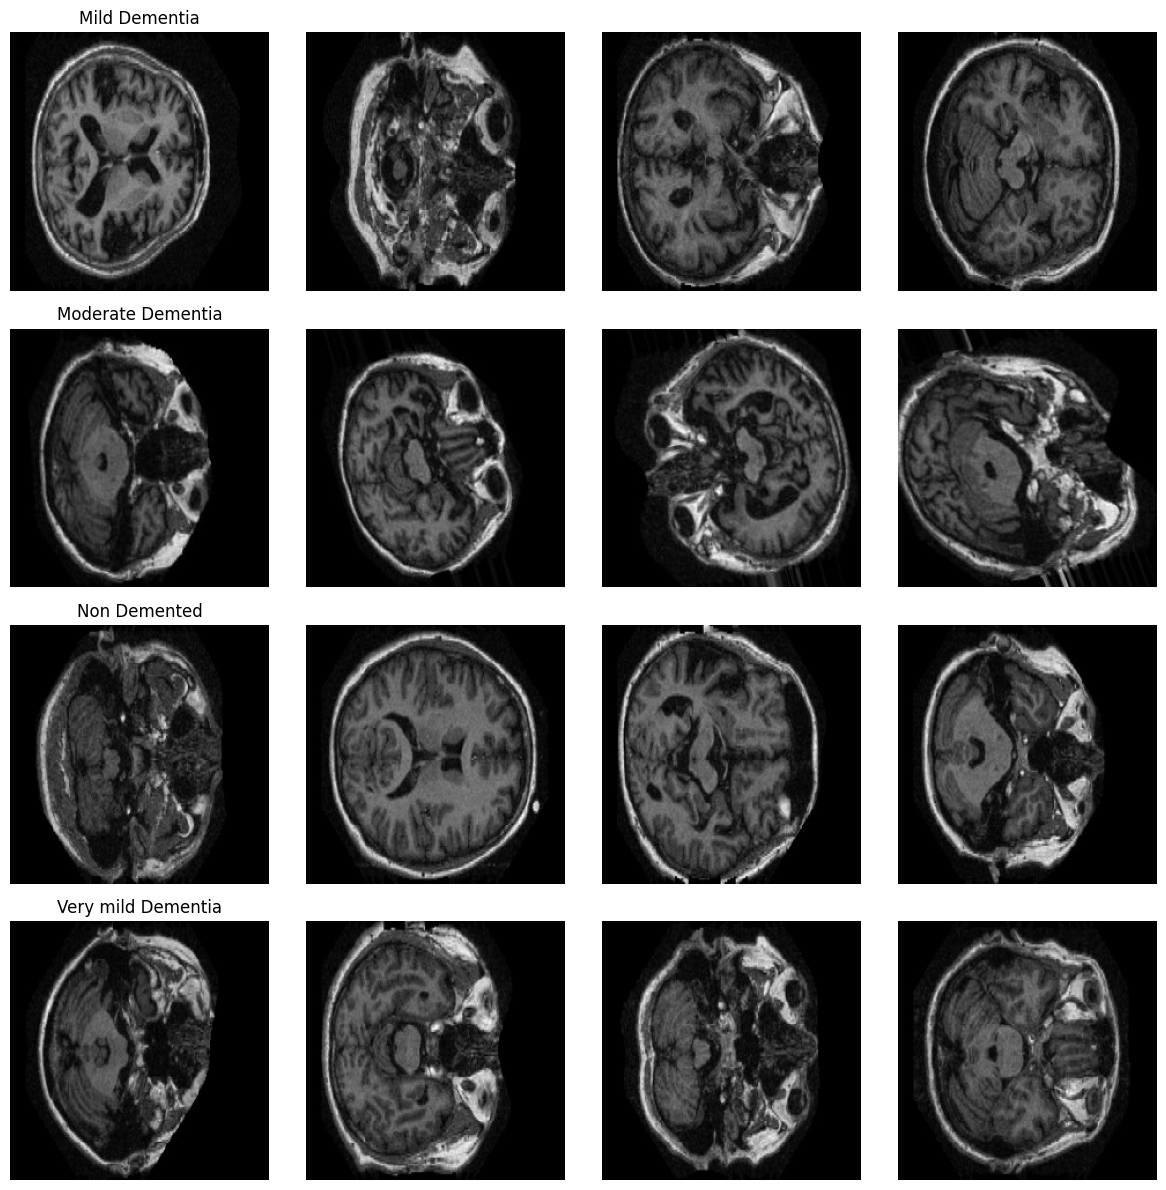

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, label in enumerate(classes):
    folder = os.path.join(balanced_dir, label)
    images = random.sample(os.listdir(folder), 4)
    for j in range(4):
        img = tf.keras.preprocessing.image.load_img(os.path.join(folder, images[j]), target_size=img_size)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(label)
plt.tight_layout()
plt.show()


# Split data (train/test)

In [ ]:
# Target folders
split_base = '/content/drive/MyDrive/Pics/BalancedData'
train_dir = os.path.join(split_base, 'train')
val_dir = os.path.join(split_base, 'val')
test_dir = os.path.join(split_base, 'test')

In [ ]:
for cls in classes:
    class_dir = os.path.join(balanced_dir, cls)
    all_imgs = os.listdir(class_dir)

    # Split into train (70%), val (15%), test (15%)
    train_imgs, temp_imgs = train_test_split(all_imgs, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for folder_name, image_list in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        dest = os.path.join(split_base, folder_name, cls)
        os.makedirs(dest, exist_ok=True)
        for img_name in image_list:
            shutil.copy(os.path.join(class_dir, img_name), os.path.join(dest, img_name))

# Load Data Using ImageDataGenerator

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=32, class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=32, class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=32, class_mode='categorical', shuffle=False
)


Found 14000 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.


# Define and Simple Compile Custom CNN

In [ ]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.6008 - loss: 0.9374 - val_accuracy: 0.9567 - val_loss: 0.1639
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 114s 170ms/step - accuracy: 0.9220 - loss: 0.2125 - val_accuracy: 0.9697 - val_loss: 0.0973
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 74s 169ms/step - accuracy: 0.9567 - loss: 0.1151 - val_accuracy: 0.9880 - val_loss: 0.0340
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 72s 165ms/step - accuracy: 0.9721 - loss: 0.0822 - val_accuracy: 0.9903 - val_loss: 0.0252
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 73s 166ms/step - accuracy: 0.9770 - loss: 0.0629 - val_accuracy: 0.9957 - val_loss: 0.0160
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 89s 182ms/step - accuracy: 0.9793 - loss: 0.0626 - val_accuracy: 0.9920 - val_loss: 0.0226
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 174ms/step - accuracy: 0.9854 - loss: 0.0424 - val_accuracy: 0.9920 - val_loss: 0.0237
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 78s 177ms/step - accuracy: 0.9862 - loss:

# Training Curves

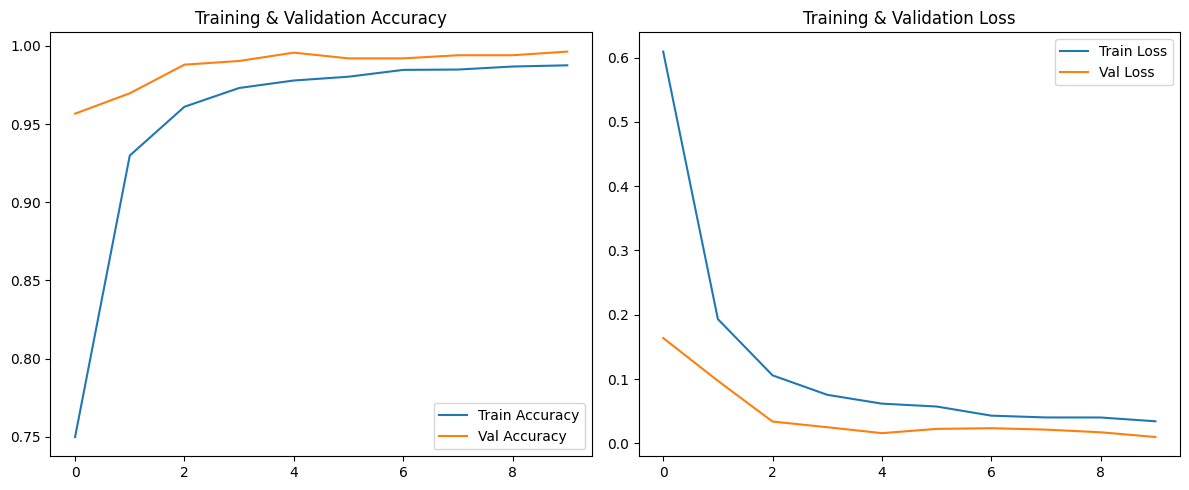

In [ ]:
# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

plt.tight_layout()
plt.show()


# Evaluate on the Test Set

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step
                    precision    recall  f1-score   support

     Mild Dementia       0.99      1.00      1.00       750
 Moderate Dementia       1.00      1.00      1.00       750
      Non Demented       1.00      0.99      0.99       750
Very mild Dementia       1.00      1.00      1.00       750

          accuracy                           1.00      3000
         macro avg       1.00      1.00      1.00      3000
      weighted avg       1.00      1.00      1.00      3000



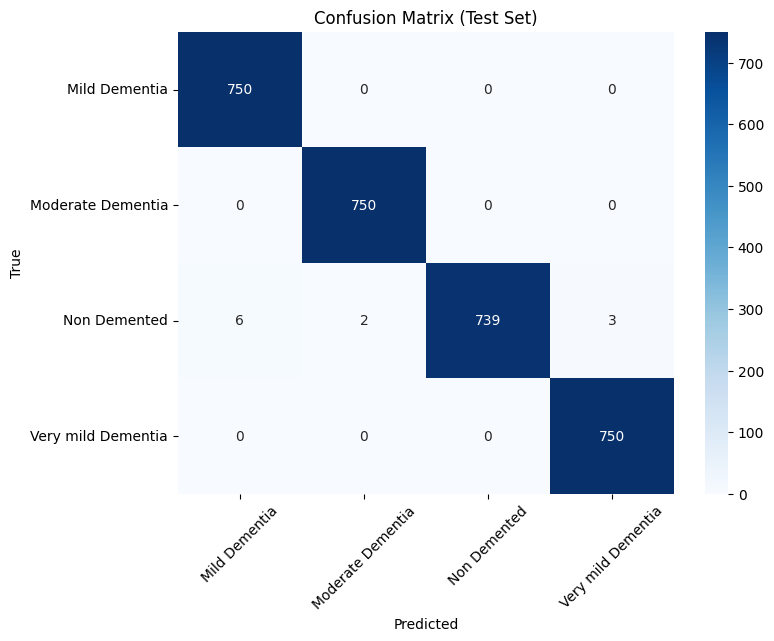

In [ ]:
# Get predictions
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# CNN with More Layers and CallBacks Model

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1
)

# Complex Model

In [ ]:
model = models.Sequential()

# Block 1
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.001), input_shape=(224,224,3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

# Block 2
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.4))

# Block 3
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.4))

# Fully connected
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,786,564 (98.37 MB)

 Trainable params: 25,785,604 (98.36 MB)

 Non-trainable params: 960 (3.75 KB)

# Training

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
117/438 ━━━━━━━━━━━━━━━━━━━━ 1:42:36 19s/step - accuracy: 0.5934 - loss: 1.3883

# Traning Curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Classification Report for Complex CNN Model

In [ ]:
# Predict
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
class_labels = list(test_data.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()